Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, models

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

path_to_train_directory = 'gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train'
path_to_test_directory =  'gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Test'

#Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

num_classes = 9
epochs = 50

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',  # Infer labels from subdirectory names
    label_mode='categorical', # Use int labels ('categorical' produces one-hot encoded labels with shape((batch_size, num_classes). sparse_categorical_crossentropy is not designed to work with one-hot encoded labels; it expects integer labels.)
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",    # Specify this is the training subset
    seed=123              # Set a seed for reproducibility
)



Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",  # Specify this is the validation subset
    seed=123
)



Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

<Figure size 640x480 with 0 Axes>

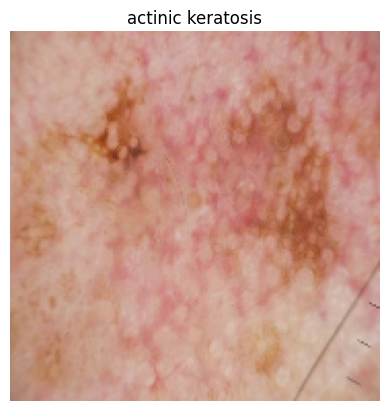

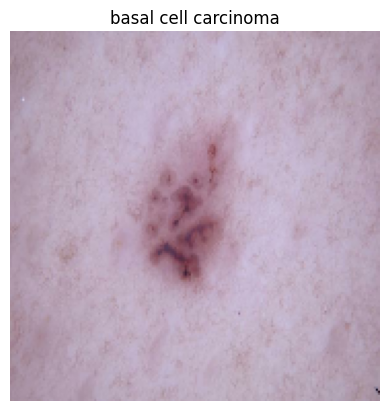

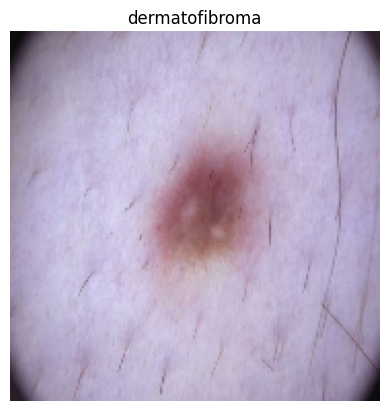

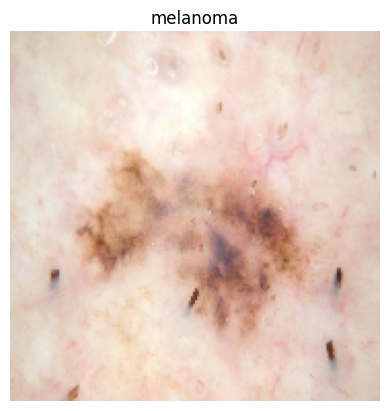

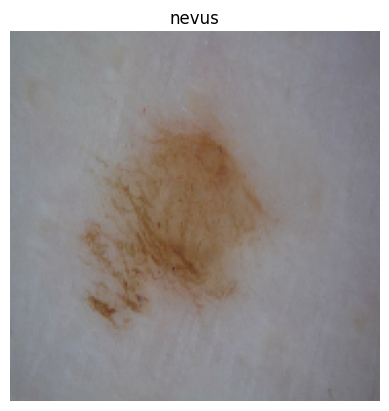

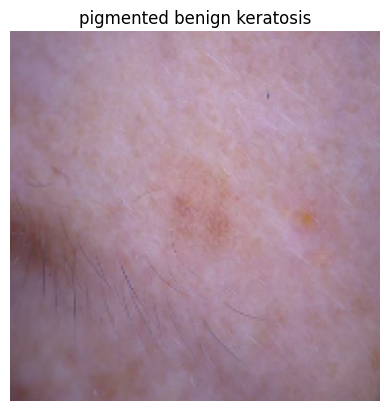

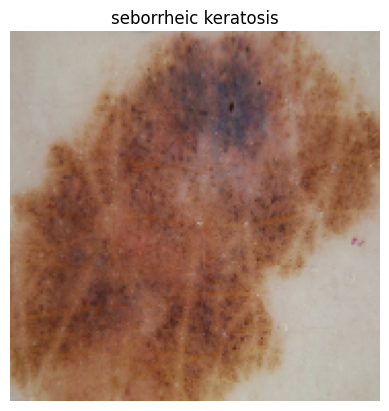

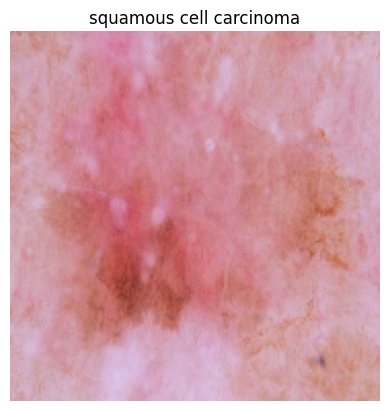

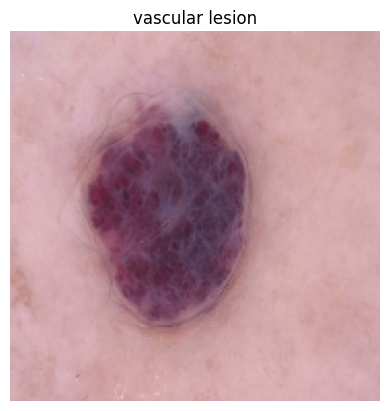

In [10]:
# Create a dictionary to store one sample per class
samples_per_class = {}

# Iterate through the training dataset
for images, labels in train_ds:
    #print("Image batch shape:", images.shape)
    #print("Label batch shape:", labels.shape)
    for i in range(images.shape[0]):  # Iterate through images in the batch
        label_index = np.argmax(labels[i])  # Get the class index

        # If this class hasn't been collected yet, store the sample
        if label_index not in samples_per_class:
            samples_per_class[label_index] = (images[i].numpy(), labels[i].numpy())

        # If we have one sample for each class, break out of the loop
        if len(samples_per_class) == num_classes:  # num_classes should be defined
            break

    if len(samples_per_class) == num_classes:
        break

# Display the collected samples
plt.figure()
#plt.figure(figsize=(10, 5))
for i in range(num_classes):
    # Check if the key 'i' exists in samples_per_class before accessing it
    if i in samples_per_class:
        #plt.subplot(1, num_classes, i + 1)
        plt.figure()
        plt.imshow(samples_per_class[i][0].astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")
    else:
        print(f"Warning: No sample found for class {i} ({class_names[i]})")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model (Without Droput Layer)
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
def normalize_image(image, label):
    """Normalizes image pixel values to the range [0, 1]."""
    image = tf.cast(image, tf.float32) / 255.0  # Convert to float32 and divide by 255
    return image, label


In [13]:
# Apply the normalization function to the training and validation dataset
train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense, Dropout

In [ ]:
model = models.Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(180,180,3)))
#model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
#model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(64,activation='relu'))

model.add(Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
# Compile the model
# Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### Visualizing training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### <b>Findings
###After the 6th, 7th Epoch , the difference between the training and Validation accuracy significantly increases, overfitting is evident.

### Create the model(<b>With Dropout<b>)


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = models.Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(180,180,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))


model.add(Flatten())

model.add(Dropout(0.30))

model.add(Dense(64,activation='relu'))

model.add(Dense(9,activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [ ]:
# Compile the model
# Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### <b>Findings:

#### After the model fit, Overfitting has been significantly reduced, however the accuracy (both training and validation) are both very low (61% / 50%)

####  Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [15]:

import numpy as np
import pandas as pd


# Create empty lists to store image paths and labels
path_list = []
lesion_list = []

# Recreate the dataset for extraction of the file_paths
# using tf.keras.utils.image_dataset_from_directory
temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=False           # Important: Disable shuffling for consistent file paths
)


# Extract file paths from the temporary dataset
path_list.extend(temp_ds.file_paths)

# Iterate through the original training dataset to get labels
for images, labels in train_ds:
    for i in range(images.shape[0]):  # Iterate through images in the batch
        # Get the class label
        label_index = np.argmax(labels[i].numpy())  # Assuming one-hot encoded labels
        label = class_names[label_index]  # Get class name from class_names list
        lesion_list.append(label)  # Append label to list

# Make sure path_list and lesion_list have the same length
# before creating a dictionary (zip requires equal lengths)
min_len = min(len(path_list), len(lesion_list))
path_list = path_list[:min_len]
lesion_list = lesion_list[:min_len]


# Create a dictionary combining the paths and labels
dataframe_dict = dict(zip(path_list, lesion_list))

# Create a Pandas DataFrame from the dictionary
original_df = pd.DataFrame(list(dataframe_dict.items()), columns=['Path', 'Label'])

# Count the occurrences of each label in the 'Label' column
label_counts = original_df['Label'].value_counts()

# Print the label counts
print(label_counts)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Label
pigmented benign keratosis    773
melanoma                      755
basal cell carcinoma          721
nevus                         677
squamous cell carcinoma       569
actinic keratosis             493
vascular lesion               493
seborrheic keratosis          456
dermatofibroma                455
Name: count, dtype: int64


#### <b>Findings <b>:
#### - Which class has the least number of samples? : <b>dermatofibroma<b>
#### - Which classes dominate the data in terms proportionate number of samples? <b>pigmented benign keratosis <b>


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [15]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [16]:
path_to_training_dataset=data_dir_train
import Augmentor
import os  # Import the 'os' module
for i in class_names:
    # Use os.path.join to correctly combine the path components
    augmented_path = os.path.join(path_to_training_dataset, i)
    p = Augmentor.Pipeline(augmented_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25907DC580>: 100%|██████████| 500/500 [00:24<00:00, 20.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A259040AD40>: 100%|██████████| 500/500 [00:19<00:00, 25.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25907DE680>: 100%|██████████| 500/500 [00:23<00:00, 21.58 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A259046F910>: 100%|██████████| 500/500 [01:21<00:00,  6.10 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A259056DA20>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25AF079300>: 100%|██████████| 500/500 [00:19<00:00, 25.69 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A259046E5C0>: 100%|██████████| 500/500 [00:41<00:00, 12.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A25AF153040>: 100%|██████████| 500/500 [00:19<00:00, 25.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A25907B7CD0>: 100%|██████████| 500/500 [00:19<00:00, 25.25 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [17]:
import glob
import os
import pandas as pd

# Get all augmented image paths
path_list_new = glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))

# Extract the corresponding labels from the directory structure
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y)))
                    for y in path_list_new]

# Create a dictionary to store image paths and labels
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

# Create a DataFrame for the augmented data
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Read the original DataFrame (if it's not already loaded)
# Assuming original_df was created in a previous cell
# original_df = pd.read_csv('path_to_original_df.csv') # Replace with actual path

# Concatenate original and augmented DataFrames (if original_df exists)
try:
    new_df = pd.concat([original_df, df2], ignore_index=True)
except NameError:
    new_df = df2
    print("original_df not found. Using only augmented data.")

# Count the occurrences of each label in the new DataFrame
label_counts_new = new_df['Label'].value_counts()

# Print the label counts for the augmented data
print(label_counts_new)

original_df not found. Using only augmented data.
Label
vascular lesion               1500
actinic keratosis             1500
seborrheic keratosis          1500
melanoma                      1500
nevus                         1500
pigmented benign keratosis    1500
basal cell carcinoma          1500
squamous cell carcinoma       1500
dermatofibroma                1500
Name: count, dtype: int64


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [18]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [19]:

# Update data_dir_train to the original training directory
data_dir_train = pathlib.Path(data_dir_train)
# Assuming path_to_training_dataset is defined and holds the path
# Or you could directly use:
# data_dir_train = pathlib.Path('gdrive/My Drive/Datasets/Melanoma_Detection_Assignment/Train')

# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',  # Infer labels from subdirectory names
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=123
)
'''
# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,  # Use the same data directory for validation
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=123
)
'''

Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### **Todo:** Create a validation dataset

In [21]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",  # Specify this is the validation subset
    seed=123
)



Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [22]:
# Apply the normalization function to the training and validation dataset
train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = models.Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(180,180,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))


model.add(Flatten())

model.add(Dropout(0.30))

model.add(Dense(64,activation='relu'))

model.add(Dense(9,activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [24]:
# Compile the model
# Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [25]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 1784s 5s/step - accuracy: 0.2258 - loss: 2.0795 - val_accuracy: 0.4299 - val_loss: 1.4998
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 128s 225ms/step - accuracy: 0.4433 - loss: 1.4484 - val_accuracy: 0.5412 - val_loss: 1.2843
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 87s 220ms/step - accuracy: 0.5009 - loss: 1.3136 - val_accuracy: 0.5812 - val_loss: 1.1490
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 85s 215ms/step - accuracy: 0.5745 - loss: 1.1548 - val_accuracy: 0.6298 - val_loss: 1.0491
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 140s 211ms/step - accuracy: 0.6058 - loss: 1.0530 - val_accuracy: 0.6673 - val_loss: 0.9494
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 88s 224ms/step - accuracy: 0.6426 - loss: 0.9586 - val_accuracy: 0.7248 - val_loss: 0.8385
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 137s 212ms/step - accuracy: 0.6748 - loss: 0.8693 - val_accuracy: 0.7127 - val_loss: 0.8079
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.7036 - loss:

#### **Todo:**  Visualize the model results

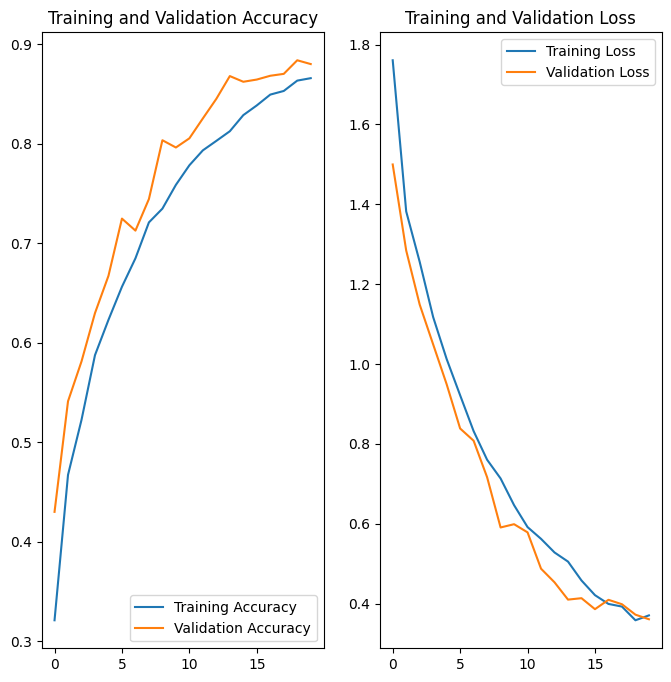

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
Post Class Reblancing (with dropout layers) , the validation accuracy has improved dramatically from ~50% to ~88%.
Overfitting has been addressed as the variance between test accuracy and training accuracy has decreased significantly.
